In [100]:
import matlab.engine
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import datetime
from scipy.io import loadmat
from collections import defaultdict
from IPython.display import clear_output
import math

eng = matlab.engine.start_matlab()

In [222]:
quietDays = np.array(eng.quiet())
# Quiet days from 2009/09/5 to 2009/09/19
# quietDays[1580-1] = 2009/09/14

year = np.int16(quietDays[1572-1][0])
month = np.int16(quietDays[1572-1][1])
day = np.int16(quietDays[1572-1][2])
# year = 2012
# month = 9
# day = 6
hour = 0
minute = 0
second = 0
numberOfDaysWithData = 6


startDateMatlab = [year, month, day, hour, minute, second]
endDateMatlab = [year, month, day+numberOfDaysWithData, hour, minute, second]

startDate = datetime.datetime(year, month, day, hour, minute, second)
endDate = datetime.datetime(year, month, day+numberOfDaysWithData, hour, minute, second)


stationsWithNoData = []
stationsNonexistentInFolder = []
stationsOut = dict()
dotsX=[]
dotsY=[]
dotsHeights=[]
stationIndicatorVariation = defaultdict(list)

mat = loadmat("../../../../opt/dir.indices/station.mat")

allMatData = mat.get("station", "none")[0]
allStationCodes=np.array([])
allStationLatgeos=np.array([])

for x in allMatData:
    allStationCodes=np.append(allStationCodes,x[1][0])
    allStationLatgeos=np.append(allStationLatgeos,x[3][0])
    
latMin=20
latMax=60
    

In [223]:
%%time
for i in range(0,allStationCodes.shape[0]): 
    if allStationLatgeos[i]>latMin and allStationLatgeos[i]<latMax:
        try:
            stationsOut[allStationCodes[i]] = eng.indices_alpha(matlab.double(startDateMatlab), matlab.double(endDateMatlab),str(allStationCodes[i]))
        except:
            stationsNonexistentInFolder.append(st)

CPU times: user 191 ms, sys: 43.6 ms, total: 234 ms
Wall time: 1.63 s


In [224]:
%%time
from collections import OrderedDict

stationsYearMagPosition = OrderedDict(OrderedDict())
stationPosition = OrderedDict()  

for x in allMatData:  
    stationsYearMagPosition[str(x[1][0])] = OrderedDict()  
    try:
        for i in range(len(x[5][0])):
            stationPosition[x[5][0][i]] = x[9][0][i], x[10][0][i]
            stationsYearMagPosition[str(x[1][0])] = stationPosition.copy()
    except:
        print("no value")

CPU times: user 73.9 ms, sys: 12 ms, total: 85.9 ms
Wall time: 81.5 ms


In [306]:
def IndicatorCalculation(dataSt, timeshift, currentDate, igrf):
    
#     a1=np.float32(dataSt.get("a1")[timeshift])
#     a2=np.float32(dataSt.get("a2")[timeshift])
#     a4=np.float32(dataSt.get("a5")[timeshift])
#     x=np.float32(dataSt.get("x")[timeshift])
    x1=np.float32(dataSt.get("x1")[timeshift])
    x2=np.float32(dataSt.get("x2")[timeshift])
#     x3=np.float32(dataSt.get("x3")[timeshift])
#     x4=np.float32(dataSt.get("x4")[timeshift])
#     x5=np.float32(dataSt.get("x5")[timeshift])
#     y=np.float32(dataSt.get("y")[timeshift])
    y1=np.float32(dataSt.get("y1")[timeshift])
#     y2=np.float32(dataSt.get("y2")[timeshift])
#     y3=np.float32(dataSt.get("y3")[timeshift])
#     y4=np.float32(dataSt.get("y4")[timeshift])
#     z=np.float32(dataSt.get("z")[timeshift])
    z1=np.float32(dataSt.get("z1")[timeshift])
#     z2=np.float32(dataSt.get("z2")[timeshift])
    
    ratio = ((math.sqrt(pow(x1, 2)+pow(y1, 2)+pow(z1, 2)))/igrf)
    return np.round(x2,10), ratio

In [307]:
def CalculateIGRF(dataSt, currentDate):    
    stLongeo=np.float32(dataSt.get("longeo"))
    stLatgeo=np.float32(dataSt.get("latgeo"))
    stAlt=np.float32(dataSt.get("alt"))
    
    currentDateMatlab = [currentDate.year, currentDate.month, currentDate.day, currentDate.hour, currentDate.minute, currentDate.second]
    b=eng.igrf(matlab.double([stLongeo]), matlab.double([stLatgeo]), matlab.double([stAlt]), matlab.double([currentDateMatlab]), nargout=4)
    return b[3]

In [308]:
%%time
stationIndicatorRatioVariation = defaultdict(list)
stationIndicatorVariation.clear()
numberOfMinutesNeededInTheTimeStamp = 1440*numberOfDaysWithData
timeBetweenValues = 30
numberOfValues = numberOfMinutesNeededInTheTimeStamp/timeBetweenValues
dataResolution = 0
dataBeforeNormalizaton = np.array([])


if float(360%(numberOfMinutesNeededInTheTimeStamp/timeBetweenValues)).is_integer():
    dataResolution = 360/(numberOfMinutesNeededInTheTimeStamp/timeBetweenValues)
    for st in stationsOut.keys():
        if stationsOut[st]:
            if stationsOut[st].get("latgeo") > latMin and stationsOut[st].get("latgeo") < latMax:
                igrf=CalculateIGRF(stationsOut[st], startDate)
                delta = endDate-startDate
                totalMinutes = (delta.total_seconds()+1)/60
                for i in range(0, np.int16(totalMinutes), timeBetweenValues):
                    try:
                        update = datetime.timedelta(minutes=i)
                        currentDate = startDate+update
                        magneticValue, ratio = IndicatorCalculation(stationsOut.get(st), i, currentDate, igrf)
                        stationIndicatorVariation[st].append(magneticValue)
                        stationIndicatorRatioVariation[st].append(ratio)
                    except:
                        None

else:
    print("!ERROR! -- Your timeBetweenValues must be a multiple of the chosen time delta's amount of minutes -- !ERROR!")
    sys.exit



CPU times: user 998 ms, sys: 12.5 ms, total: 1.01 s
Wall time: 1.03 s


In [309]:
normalizedStationIndicatorVariation = defaultdict(list)
normalized01StationIndicatorVariation = defaultdict(list)
maxValueinDataset=0
minValueinDataset=0
  

def normalizeWithGivenBounds(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]               

def ManuallyNormalizeData01():
    global maxValueinDataset
    global minValueinDataset
    max_values = np.array([])
    min_values = np.array([])
    max_values_ratio = np.array([])
    min_values_ratio = np.array([])
    
    for st in allStationCodes:
        if stationIndicatorVariation[st]:
            if not math.isnan(stationIndicatorVariation[st][0]):
                max_values = np.append(max_values, max(stationIndicatorVariation[st])) 
                min_values = np.append(min_values, min(stationIndicatorVariation[st]))
                max_values_ratio = np.append(max_values_ratio, max(stationIndicatorRatioVariation[st])) 
                min_values_ratio = np.append(min_values_ratio, min(stationIndicatorRatioVariation[st])) 

    totalMax = max(max_values)
    totalMin = min(min_values)
    totalMaxRatio = max(max_values_ratio)
    totalMinRatio = min(min_values_ratio)
    maxValueinDataset = totalMax
    minValueinDataset = totalMin
    
    bounds = np.array([0,1])   
    boundsRatio = np.array([-1,1])   
    for st in allStationCodes:
        if stationIndicatorVariation[st]:
            localMax = max(stationIndicatorVariation[st])
            localMin = min(stationIndicatorVariation[st])
            localMaxRatio = max(stationIndicatorRatioVariation[st])
            localMinRatio = min(stationIndicatorRatioVariation[st])
            
#             stationIndicatorRatioVariation[st]=normalizeWithGivenBounds(np.array(stationIndicatorRatioVariation[st]), {'actual': {'lower': localMinRatio, 'upper': localMaxRatio}, 'desired': {'lower': boundsRatio[0], 'upper': boundsRatio[1]}})
            #When the ratio is far from the reference it's value tends to 0, when the ration corresponds to the reference the value tends to 1
            IndicatorVariationAppliedRatio=stationIndicatorVariation.copy()
#             for i in range(0, len(stationIndicatorVariation[st])):
#                 IndicatorVariationAppliedRatio[st][i] = stationIndicatorVariation[st][i]*stationIndicatorRatioVariation[st][i]
            normalized01StationIndicatorVariation[st] = normalizeWithGivenBounds(np.array(IndicatorVariationAppliedRatio[st]), {'actual': {'lower': localMin, 'upper': localMax}, 'desired': {'lower': bounds[0], 'upper': bounds[1]}})



# NormalizeDataGauss()
# NormalizeData01()
ManuallyNormalizeData01()

In [310]:
def indexValueOnLocalTime(array, st, i):
    numberOfValuesLong = array.shape[1]
    localTimeValuesArray = np.full((180, numberOfValuesLong), np.nan)
    long = float(stationsOut[st].get("longeo"))
    shiftValues = np.int16(np.round((long*4)/timeBetweenValues,0))
    initialShiftValues = shiftValues
    decreasingIndex=0
    increasingIndex=0
    for y in range(numberOfValues/numberOfDaysWithData,numberOfValues-(numberOfValues/numberOfDaysWithData)):
        if y+shiftValues>=array.shape[1]:
            localTimeValuesArray[i][shiftValues-decreasingIndex-1] = array[i][(numberOfValues/numberOfDaysWithData)-decreasingIndex-1]
            decreasingIndex+=1
        else:
            localTimeValuesArray[i][np.int16(shiftValues+increasingIndex)] = array[i][y]
            increasingIndex+=1
    return localTimeValuesArray[i] 

In [311]:
indicatorVariationArray = np.full((180, numberOfValues), np.nan)
localIndicatorVariationArray = np.full_like(indicatorVariationArray, np.nan)
indicatorVariationArrayLocalTime = np.full((180, numberOfValues), np.nan)
localNormalized01StationIndicatorVariation = np.full((180, len(normalized01StationIndicatorVariation[normalized01StationIndicatorVariation.keys()[1]])), np.nan)
stationsPerLat = defaultdict(list)
def makeIndicatorVariationArray(normalized):
    intermediateLocalIndicatorVariationArray = np.empty_like(localIndicatorVariationArray)
    intermediateLocalNormalized01StationIndicatorVariation = np.empty_like(localNormalized01StationIndicatorVariation)
    alreadyFilled = False
    previousSt=''
    stationsPerLat.clear()
    for st in stationsOut.keys():
        alreadyFilled=False
        for i in range(-90, 90):
            if not isinstance(stationsOut[st], matlab.mlarray.double):
                if stationsOut[st].get('longeo')>0:
                    if i == np.round(np.int16(stationsOut[st].get("latgeo")),0):
                        stationsPerLat[i+90].append(st)
                        stationsPerLat[i+90].append(stationsOut[st].get("longeo"))
                        if len(stationsPerLat[i+90])>1:
                            alreadyFilled=True
                        if normalized:
                            if normalized01StationIndicatorVariation[st]:
                                if alreadyFilled==True:
                                    stName = stationsPerLat[i+90][stationsPerLat[i+90].index(min(stationsPerLat[i+90]))-1]
                                    localIndicatorVariationArray[i+90] = normalized01StationIndicatorVariation[stName]
                                    localNormalized01StationIndicatorVariation[i+90] = normalized01StationIndicatorVariation[stName]
                                    indicatorVariationArrayLocalTime[i+90] = indexValueOnLocalTime(localNormalized01StationIndicatorVariation, stName, i+90)
                                    indicatorVariationArray[i+90] = localIndicatorVariationArray[i+90]
                                else:
                                    localIndicatorVariationArray[i+90] = normalized01StationIndicatorVariation[st]
                                    localNormalized01StationIndicatorVariation[i+90] = normalized01StationIndicatorVariation[st]
                                    indicatorVariationArrayLocalTime[i+90] = indexValueOnLocalTime(localNormalized01StationIndicatorVariation, st, i+90)
                                    indicatorVariationArray[i+90] = localIndicatorVariationArray[i+90]

                            else: 
                                if len(stationIndicatorVariation[st])!=0:
                                    indicatorVariationArray[i+90]=stationIndicatorVariation[st]
                                    indicatorVariationArrayLocalTime[i+90] = indexValueOnLocalTime(indicatorVariationArray, st, i+90)
                                else:
                                    None
                else:
                    None
            previousSt=st
                    
makeIndicatorVariationArray(True)

In [312]:
indicatorVariationArrayResized = np.empty([latMax-latMin, numberOfValues-((numberOfValues/numberOfDaysWithData)*2)])
indicatorVariationArrayLocalTimeResized = np.empty([latMax-latMin, numberOfValues-((numberOfValues/numberOfDaysWithData)*3)])
m=0
for i in range(latMin+90, latMax+90):
    a=0
    for y in range(numberOfValues/numberOfDaysWithData,numberOfValues-(numberOfValues/numberOfDaysWithData)):
        indicatorVariationArrayResized[m][a]=indicatorVariationArray[i][y]
        a+=1
    m+=1
indicatorVariationArray = np.empty_like(indicatorVariationArrayResized)
indicatorVariationArray=indicatorVariationArrayResized[:]

m=0
for i in range(latMin+90, latMax+90):
    a=0
    for y in range(numberOfValues/numberOfDaysWithData,numberOfValues-(numberOfValues/numberOfDaysWithData)*2):
        indicatorVariationArrayLocalTimeResized[m][a]=indicatorVariationArrayLocalTime[i][y]
        a+=1
    m+=1
indicatorVariationArrayLocalTime = np.empty_like(indicatorVariationArrayLocalTimeResized)
indicatorVariationArrayLocalTime=indicatorVariationArrayLocalTimeResized[:]


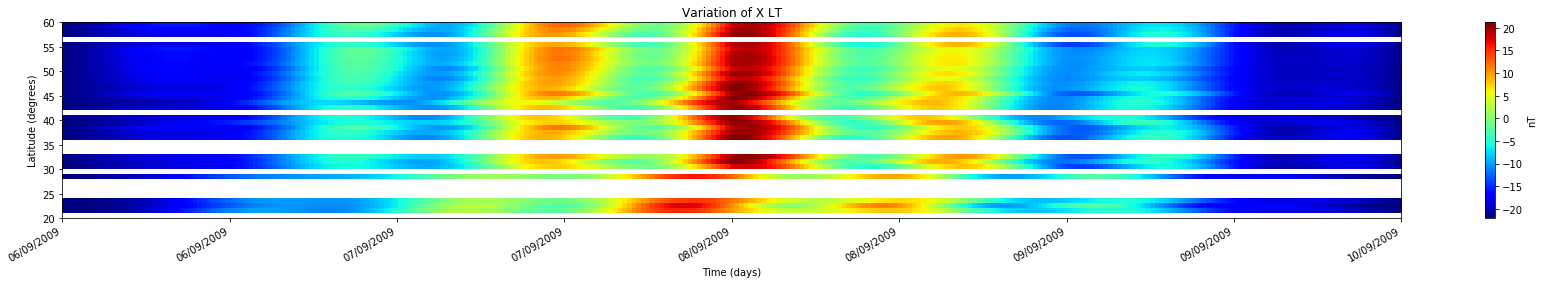

In [329]:
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import matplotlib.dates as mdates

fig, ax = plt.subplots()

x_lims = list()
x_lims.append(startDate)
x_lims.append(endDate-datetime.timedelta(days=2))
x_lims = mdates.date2num(x_lims)




ax.imshow(correlation, origin='lower', cmap=plt.get_cmap('jet') , aspect='auto',extent=[x_lims[0],x_lims[1],latMin,latMax])
#indicatorVariationArray, ReconstructedArray, indicatorVariationArrayIncreasedResolution, indicatorVariationArrayLocalTime


ax.xaxis_date()
fig.autofmt_xdate()
x_lims = mdates.DateFormatter("%d/%m/%Y")
ax.xaxis.set_major_formatter(x_lims)


fig.set_size_inches(30,4)
ax.set_title("Variation of X LT")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Latitude (degrees)")
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('jet'), norm=plt.Normalize(vmin=minValueinDataset, vmax=maxValueinDataset))
sm._A = []
clb=fig.colorbar(sm)
clb.set_label("nT")
fig.savefig('OutputMatrix.png')
fig.show()

In [314]:
flipMatrix = indicatorVariationArrayLocalTime.T

In [316]:
flipMatrix = np.nan_to_num(flipMatrix)

In [317]:
correlation = np.empty([144,40])
for i in range(144):
    correlation[i] = np.correlate(flipMatrix[100], flipMatrix[i], 'same')

In [328]:
correlation = np.empty([40,287])
for i in range(0,40):
    correlation[i] = np.correlate(indicatorVariationArrayLocalTime[i], indicatorVariationArrayLocalTime[20], 'full')

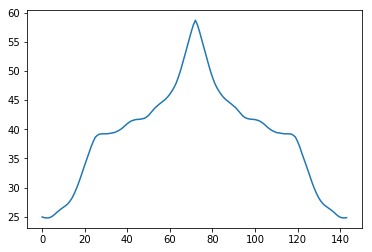

In [285]:
plt.plot(np.correlate(indicatorVariationArrayLocalTime[28], indicatorVariationArrayLocalTime[28], 'same'))

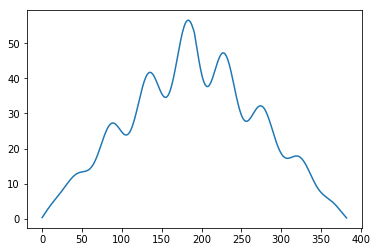

In [208]:
from scipy import signal
fft = signal.fftconvolve(indicatorVariationArrayLocalTime[35],indicatorVariationArrayLocalTime[25], mode='full')
plt.plot(fft)

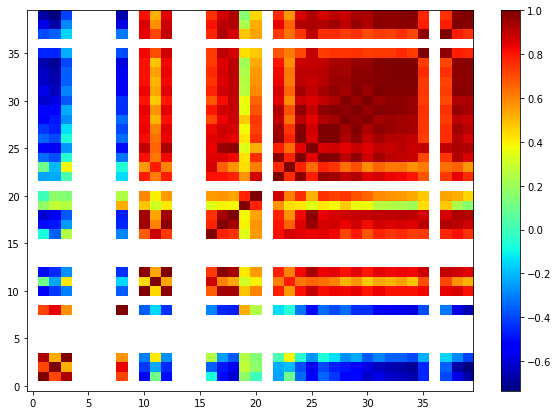

In [99]:
fig, axCorr = plt.subplots()
fig.set_size_inches(10,7)
plot = axCorr.imshow(np.corrcoef(indicatorVariationArrayLocalTime), origin='lower', cmap=plt.get_cmap('jet') , aspect='auto')
fig.colorbar(plot)
fig.show()
fig.savefig("correlationMatrix")

In [311]:
for i in range(latMin+90,latMax+90):
    print "{}--{}".format(i-90, stationsPerLat[i])

20--[]
21--[u'hon', 202.0, u'phu', 105.95]
22--[u'tam', 5.53]
23--[u'gzh', 112.5]
24--[]
25--[]
26--[]
27--[]
28--[u'gui', 343.57]
29--[]
30--[u'bsl', 270.36]
31--[u'kny', 130.88]
32--[u'tuc', 249.27]
33--[]
34--[]
35--[]
36--[u'kak', 140.18, u'sfs', 354.055, u'lzh', 103.84]
37--[u'frn', 240.28]
38--[u'frd', 282.63]
39--[u'spt', 355.65]
40--[u'ebr', 0.333, u'izn', 29.72, u'bmt', 116.2, u'bou', 254.76]
41--[]
42--[u'aqu', 13.32, u'pag', 24.2]
43--[u'mmb', 144.19, u'aaa', 76.9]
44--[u'sua', 26.25, u'gck', 20.8]
45--[u'ott', 284.448]
46--[u'thy', 17.89]
47--[u'hrb', 18.19, u'nck', 16.72, u'stj', 307.323]
48--[u'vic', 236.58, u'clf', 2.27, u'bfo', 8.325, u'new', 242.88, u'fur', 11.28]
49--[u'bdv', 14.02, u'lvv', 23.75]
50--[u'kiv', 30.3, u'mab', 5.682, u'dou', 4.6]
51--[u'had', 355.52, u'val', 349.75, u'bel', 20.789]
52--[u'irt', 104.45, u'ngk', 12.68, u'pet', 158.248]
53--[u'wng', 9.07]
54--[u'hlp', 18.811, u'nvs', 83.23, u'mea', 246.653]
55--[u'esk', 356.8, u'shu', 199.54]
56--[]
57--[u'

In [58]:
ReconstructedArray = np.array([])
predictionArray = np.array([])

def PredictIndicatorForAllLatitudes(baseArray):
    predictionArray = np.empty_like(baseArray)
    
    predictionArray=np.copy(baseArray)
    
#     params = ParametersTuningPoly(predictionArray,predictionArray.shape[1]/2)
    modelTuned = ParametersTuningPoly(predictionArray,baseArray.shape[1]/2)
    for i in range(0,baseArray.shape[0]):
        specificLatitudeTimePrediction = np.full(baseArray.shape[1], np.nan)
        if math.isnan(baseArray[i][5]):
            for y in range(5,baseArray.shape[1]):  
                clear_output(wait=True)
#                 print("Latitude index {} predicted out of {} in total, value: {}".format(i+latMin, baseArray.shape[0]+latMin,y))
#                 print("Hyper parameters {}".format(modelTuned))
                specificLatitudeTimePrediction[y] = GetIndicatorLongPrediction(i,y,modelTuned,predictionArray)
            predictionArray[i] = specificLatitudeTimePrediction
    return predictionArray

ReconstructedArray = PredictIndicatorForAllLatitudes(indicatorVariationArrayLocalTime)

NameError: global name 'ParametersTuningPoly' is not defined

In [66]:
def IncreaseLatitudeResolution(array,resolutionValue):
    insertionArray = np.full((array.shape[0]*resolutionValue,array.shape[1]),np.nan)
    y=0
    for i in range(0, array.shape[0]):
        insertionArray[y] = array[i]
        y+=resolutionValue
    return insertionArray

indicatorVariationArrayIncreasedResolution = IncreaseLatitudeResolution(indicatorVariationArrayLocalTime,3)

In [498]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Imputer

RMSE_array_true=np.full([((toLat-latMin)-(fromLat-latMin))*ReconstructedArray.shape[1]+1,1],np.nan)
RMSE_array_pred=np.full([((toLat-latMin)-(fromLat-latMin))*ReconstructedArray.shape[1]+1,1],np.nan)

for i in range(fromLat-latMin, toLat-latMin):
    RMSE_array_pred = np.append(RMSE_array_pred,ReconstructedArray[i])
    RMSE_array_true = np.append(RMSE_array_true,indicatorVariationArrayLocalTime[i])

imp = Imputer(missing_values=np.nan, strategy='mean')
RMSE_array_pred=imp.fit_transform(RMSE_array_pred.reshape(RMSE_array_pred.shape[0],1)).reshape(RMSE_array_pred.shape[0])
RMSE_array_true=imp.fit_transform(RMSE_array_true.reshape(RMSE_array_true.shape[0],1)).reshape(RMSE_array_true.shape[0])

print('Percentage RMSE : {}% accuracy'.format(np.round((1-mean_squared_error(RMSE_array_true,RMSE_array_pred))*100,3)))

Percentage RMSE : 98.938% accuracy


In [51]:
def GetIndicatorLongPrediction(latitude,longitude, params, baseArray):
    indicatorLatVariation = np.array([])
    for i in range(0, baseArray.shape[0]):
        indicatorLatVariation = np.append(indicatorLatVariation, baseArray[i][longitude])
    y = np.array(indicatorLatVariation)
    x = np.arange(0, baseArray.shape[0], 1)
    x,y = RemoveInfNan(x, y)
    return PolyRegression(x,y,params).predict(latitude)
#     return SupportVectorRegression(x,y,params).predict(latitude)

In [52]:
def RemoveInfNan(latValues, indicatorValues):
    indexDeleteY = np.array([])
    for i in range(0, indicatorValues.shape[0]):
        if math.isinf(indicatorValues[i]) or math.isnan(indicatorValues[i]):
            indexDeleteY = np.append(indexDeleteY, i)
    newY = np.delete(indicatorValues, indexDeleteY)
    newX = np.delete(latValues, indexDeleteY)
    newY=newY.reshape(newY.shape[0],1)
    newX=newX.reshape(newY.shape[0],1)
    
    return newX, newY

In [53]:
from sklearn.svm import SVR

def SupportVectorRegression(latValues, indicatorValues,params):
    svr_rbf = SVR(kernel='rbf', C=params['C'], gamma=params['gamma'])
    model = svr_rbf.fit(latValues, indicatorValues)
    
    return model

def PolyRegression(latValues, indicatorValues, params):
#     params = {'polynomialfeatures__degree': np.array([16]), 'linearregression__fit_intercept': [True, False], 'linearregression__normalize': [True, False]}
#     poly_grid = GridSearchCV(PolynomialRegression(), params, cv=10, scoring='r2', verbose=1) #Scoring with coefficient of determination r2
    poly_grid = PolynomialRegression()
    poly_grid.set_params(**params)
    poly_grid.fit(latValues, indicatorValues)
#     print("Best hyper parameters found at: {}".format(poly_grid.best_params_))
#     print("With {}% accuracy".format(poly_grid.best_score_))
    return poly_grid

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

def ParametersTuning(baseArray,long):
    indicatorLatVariation = np.array([])
    for i in range(0, baseArray.shape[0]):
        indicatorLatVariation = np.append(indicatorLatVariation, baseArray[i][long])

    y = np.array(indicatorLatVariation)
    x = np.arange(0, baseArray.shape[0], 1)

    x, y = RemoveInfNan(x, y)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0)
    
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     ax1.scatter(X_train, y_train)
#     ax2.scatter(X_test, y_test)
#     fig.set_size_inches(15,5)
    
    parameters = {'kernel':['rbf'], 'gamma': [1e-4, 1e-3],'C': [1, 10, 50, 100]}
    svr = GridSearchCV(SVR(), parameters)
    svr.fit(X_train, y_train)
    print('score',svr.score(X_test, y_test))
    modelBestParams = svr.best_params_
    print ("Parameters tuning finished, best params: {}".format(modelBestParams))
    return modelBestParams

def ParametersTuningPoly(baseArray,long):
    indicatorLatVariation = np.array([])
    for i in range(0, baseArray.shape[0]):
        indicatorLatVariation = np.append(indicatorLatVariation, baseArray[i][long])

    y = np.array(indicatorLatVariation)
    x = np.arange(0, baseArray.shape[0], 1)

    x, y = RemoveInfNan(x, y)
    
    paramsTuning = {'polynomialfeatures__degree': np.arange(2,5,1), 'linearregression__fit_intercept': [True, False], 'linearregression__normalize': [True, False]}
    poly_gridTuning = GridSearchCV(PolynomialRegression(), paramsTuning, cv=10, scoring='r2', verbose=1) #Scoring with coefficient of determination r2
    poly_gridTuning.fit(x, y)
#     print("Best hyper parameters found at: {}".format(poly_gridTuning.best_params_))
#     print("With {}% accuracy".format(poly_gridTuning.best_score_))
    return poly_gridTuning.best_params_

In [55]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

/home/cristille/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/home/cristille/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  import sys
/home/cristille/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'kernel': 'rbf', 'C': 100, 'gamma': 1e-05}


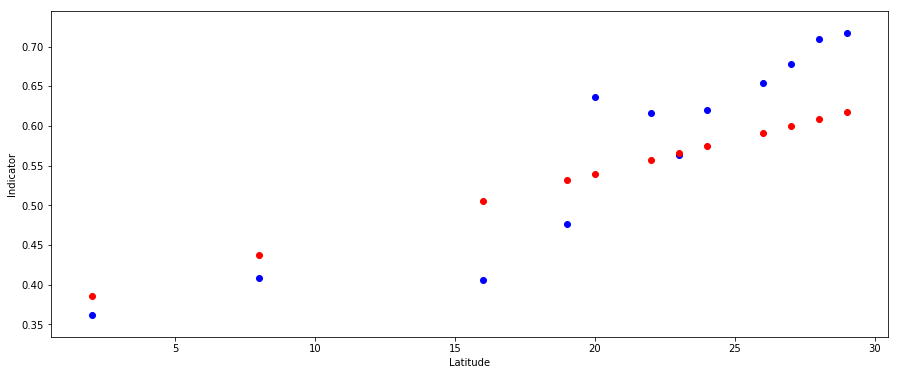

In [44]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

def printModelFitForGivenLong(baseArray, long):
    indicatorLatVariation = np.array([])
    for i in range(0, baseArray.shape[0]):
        indicatorLatVariation = np.append(indicatorLatVariation, baseArray[i][long])

    y = np.array(indicatorLatVariation)
    x = np.arange(0, baseArray.shape[0], 1)


    x, y = RemoveInfNan(x, y)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0)
    
    



    parameters = {'kernel':['rbf'], 'gamma': [1e-5, 1e-4, 1e-3],'C': [1, 10, 50, 100]}
    svr = GridSearchCV(SVR(), parameters)
    model=svr.fit(x, y)
    print svr.best_params_

    newPred = model.predict(X_test)

    
    
    plt.figure(figsize=(15,6))
    plt.xlabel("Latitude")
    plt.ylabel("Indicator")
    plt.scatter(x, y, c = 'blue')
    plt.scatter(x, model.predict(x), c='red')
    plt.show()
    
printModelFitForGivenLong(indicatorVariationArrayLocalTime, 140)

/home/cristille/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/home/cristille/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  import sys


Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best hyper parameters found at: {'linearregression__normalize': True, 'polynomialfeatures__degree': 2, 'linearregression__fit_intercept': False}
With -18.2884399289% accuracy


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.3s finished


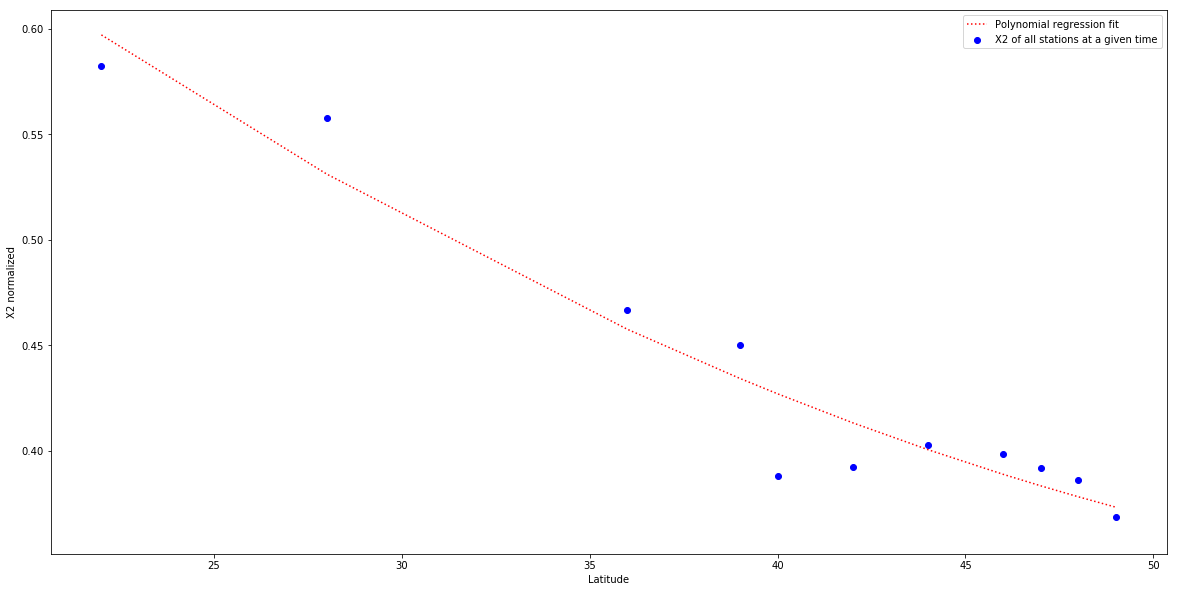

In [102]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

def printModelFitForGivenLong(baseArray, long):
    indicatorLatVariation = np.array([])
    for i in range(0, baseArray.shape[0]):
        indicatorLatVariation = np.append(indicatorLatVariation, baseArray[i][long])

    y = np.array(indicatorLatVariation)
    x = np.arange(20,50, 1)
    

    x, y = RemoveInfNan(x, y)
#     X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0)
    
    
    def PolynomialRegression(degree=2, **kwargs):
        return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

    params = {'polynomialfeatures__degree': np.arange(2,5,1), 'linearregression__fit_intercept': [True, False], 'linearregression__normalize': [True, False]}
    poly_grid = GridSearchCV(PolynomialRegression(), params, cv=10, scoring='r2', verbose=1) #Scoring with coefficient of determination r2
    poly_grid.fit(x, y)
    print("Best hyper parameters found at: {}".format(poly_grid.best_params_))
    print("With {}% accuracy".format(poly_grid.best_score_))
    
    
    
    plt.figure(figsize=(20,10))
    plt.xlabel("Latitude")
    plt.ylabel("X2 normalized")
    plt.scatter(x, y, c = 'blue', label='X2 of all stations at a given time')
    plt.plot(x, poly_grid.predict(x), "r:", label='Polynomial regression fit')
    plt.legend(loc = 'best')
    plt.savefig("figPrintModelFitForGivenLong.png")
    plt.show()
    
    
printModelFitForGivenLong(indicatorVariationArrayLocalTime, 2500)



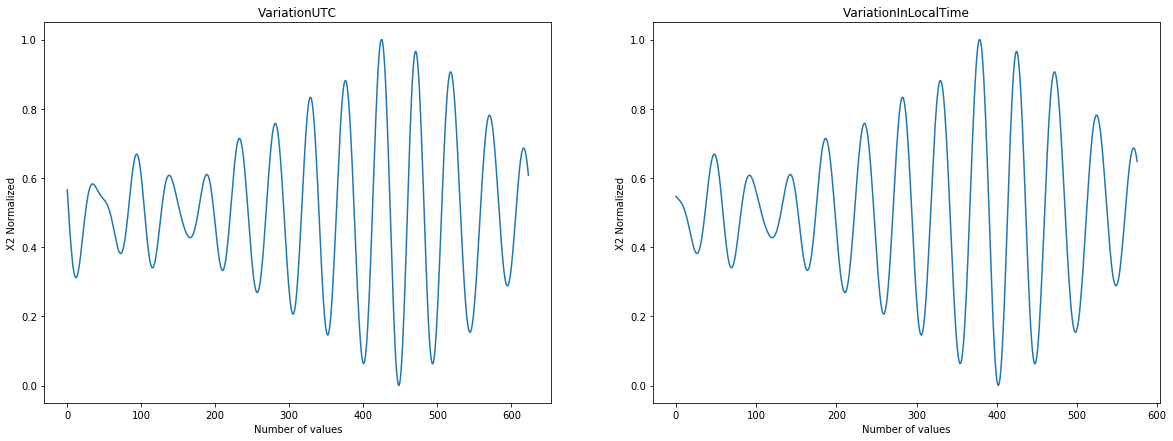

In [27]:
stationLat = 46+90
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20,7)
x = np.arange(0,indicatorVariationArray[abs(stationLat-90)-latMin].shape[0],1)
x1 = np.arange(0,indicatorVariationArrayLocalTime[abs(stationLat-90)-latMin].shape[0],1)
ax1.set_title("VariationUTC")
ax2.set_title("VariationInLocalTime")
ax2.plot(indicatorVariationArrayLocalTime[abs(stationLat-90)-latMin].reshape(indicatorVariationArrayLocalTime[abs(stationLat-90)-latMin].shape[0],1))
ax1.plot(indicatorVariationArray[abs(stationLat-90)-latMin].reshape(indicatorVariationArray[abs(stationLat-90)-latMin].shape[0],1))

ax1.set_xlabel("Number of values")
ax1.set_ylabel("X2 Normalized")
ax2.set_xlabel("Number of values")
ax2.set_ylabel("X2 Normalized")
plt.show(fig)
fig.savefig("VariationUTC_LocalTime.png")

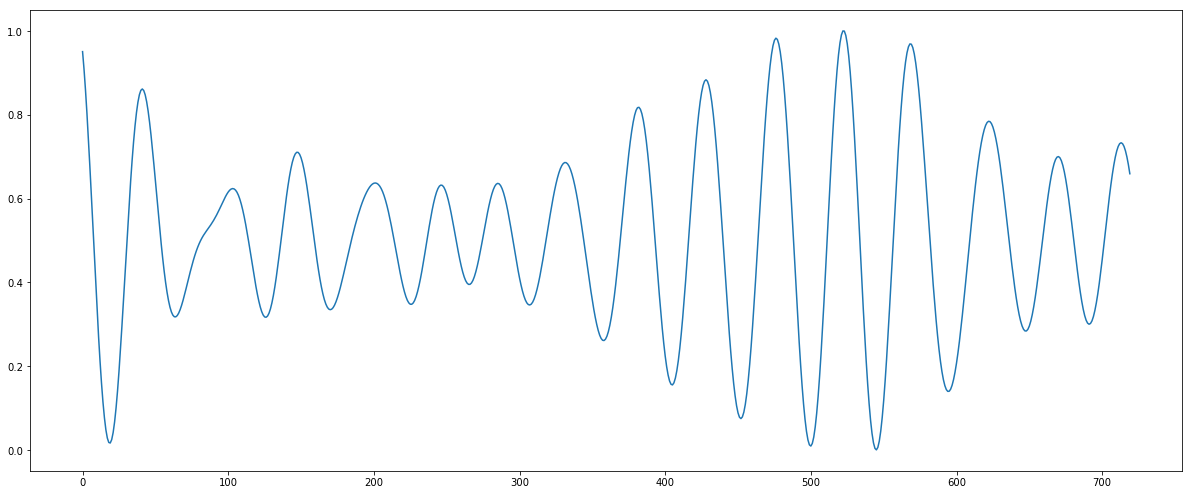

In [23]:
y = np.array(normalized01StationIndicatorVariation["clf"])
x = np.arange(0, y.shape[0])
fig= plt.figure(figsize=(20,8))
axes= fig.add_axes([0.8,0.8,0.8,0.8])
axes.plot(x,y)
plt.show()

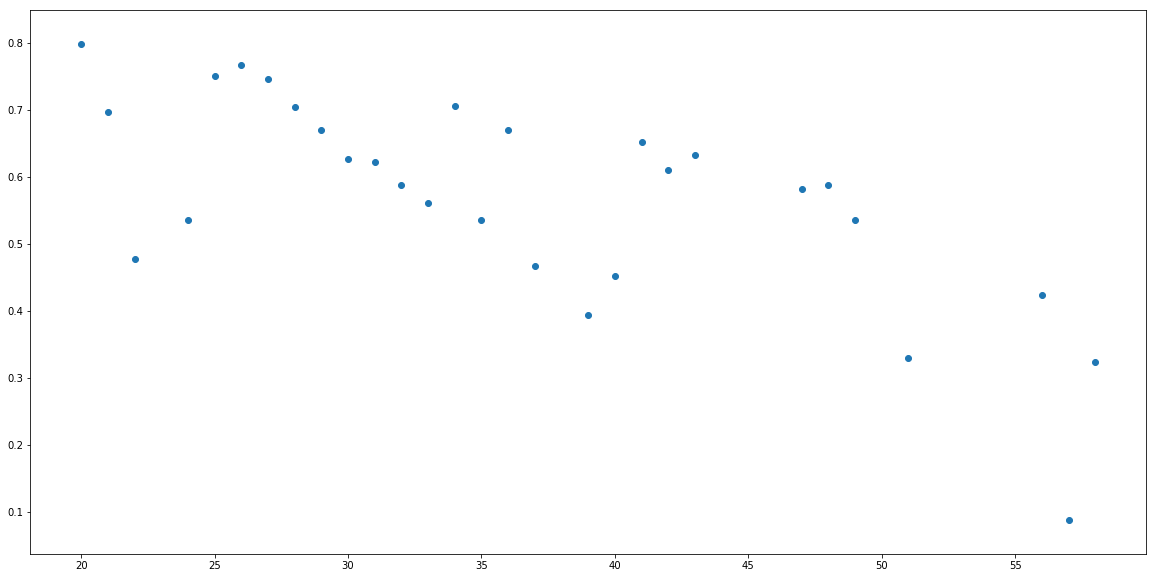

In [28]:
indicatorLatVariation = np.array([])
xLat =  np.array([])
for i in range(0, indicatorVariationArray.shape[0]):
    indicatorLatVariation = np.append(indicatorLatVariation, indicatorVariationArrayLocalTime[i][100])
    
xLat = np.arange(latMin, latMax, 1)
fig, ax1 = plt.subplots()
plotArray = np.flip(indicatorLatVariation)
ax1.scatter(xLat, plotArray.reshape(indicatorLatVariation.shape[0], 1))
fig.set_size_inches(20,10)

In [533]:
# REMOVE LATITUDES VALUES FOR TESTING PURPOSE ONLY
fromLat=46
toLat=50

target=np.full((toLat-fromLat, indicatorVariationArrayLocalTime.shape[1]), np.nan)
c=0
for i in range(fromLat,toLat):
    target[c]=indicatorVariationArrayLocalTime[i-latMin]
    indicatorVariationArrayLocalTime[i-latMin]=np.full(indicatorVariationArrayLocalTime.shape[1],np.nan)
    c+=1
    
# REMOVE ONLY ONE LATITUDE
latitudeToRemove=28
indicatorVariationArrayLocalTime[latitudeToRemove-latMin]=np.full(indicatorVariationArrayLocalTime.shape[1],np.nan)

NameError: name 'toLat' is not defined